# COMPROBACIÓN EXPERIMENTAL DEL PRINCIPIO DE FUNCIONAMIENTO DE LA ECOSONDA 

#### Librerias a Utilizar

In [1]:
import os
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from lmfit import  Model

In [2]:
document='Hoja de Datos' #Documento de drive a manejar
drive = False
fsheet= None 
path = os.getcwd()
path = path[:path.rfind('/')+1]

In [3]:
def move_file(origin, destiny):
    os.rename(origin, destiny)

In [4]:
def get_drive_sheet():
    #Obtener datos de la hoja de datos
    scope = ['https://spreadsheets.google.com/feeds']
    creds = ServiceAccountCredentials.from_json_keyfile_name(path+'client_secret.json', scope)
    client = gspread.authorize(creds)
    return client.open(document)

#### Funcion para obtener los datos desde google sheets o un archivo local

In [5]:
def get_data():
    #Obtener directorio del JSON con las credenciales
    df={}
    if drive:
        fsheet=get_drive_sheet()
    #     tablas=[]
        for i in fsheet.worksheets():
#             tablas.append(i.get_all_records()) #get all shetts as a list
            df.update({i.title:pd.DataFrame(i.get_all_records())})
            pd.DataFrame(i.get_all_records()).to_pickle(document+i.title+".pk1")
            move_file(document+i.title+".pk1", 'database/'+document+i.title+".pk1")
    else:
        files = os.listdir(os.getcwd()+'/database/')

        for f in files:
            if '.pk1' in f:
                df.update({f.replace('.pk1', '').replace(document, ''):pd.read_pickle('database/'+f)})
       
    return df

#### Funcion para R cuadrado

In [6]:
def R_square(yydata, ydata):
    residuals = ydata- yydata
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [7]:
df= get_data()

#### Tabla 1. Amplitud de voltaje de la señal del receptor, para α=45°como función de β

In [8]:
df['Tabla 1'].sort_values(['betha', 'U'], ascending=[1, 0], inplace=True)
# df['Tabla 1'].set_index('betha', inplace=True)
df['Tabla 1']

U  betha
13  0.16     15
12  0.24     20
11  0.24     25
10  0.48     30
9   0.88     35
8   2.64     40
0   4.00     45
1   2.24     50
2   1.04     55
3   0.48     60
4   0.24     65
5   0.16     70
6   0.24     75
7   0.24     80

### Calculo y ajuste de los datos para la tabla1.

In [9]:
x = df['Tabla 1'].loc[:,'betha']
y = df['Tabla 1'].loc[:,'U']

mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y*(x - mean)**2))

xx=np.linspace(x.min(), x.max(), 100) #Puntos para graficar la regresion lineal

In [10]:
mean, sigma

(45.632530120481924, 40.257753874104203)

#### Funcion Gaussiana

### $$f_{x}=\frac{a}{\sigma\sqrt{2\pi}}e^{-\frac{(x-x_{0})^2}{2\sigma^2}}$$

In [11]:
def gaussian(x, amp, cen, wid):
    "1-d gaussian: gaussian(x, amp, cen, wid)"
    return (amp/(np.sqrt(2*np.pi)*wid)) * np.exp(-(x-cen)**2 /(2*wid**2))
#     return amp * np.exp(-(x-cen)**2 /wid)

gmodel = Model(gaussian)
result = gmodel.fit(y, x=x, amp=1, cen=mean, wid=sigma)

result.best_values

{'amp': 56.497846466887715,
 'cen': 44.745680805622754,
 'wid': 6.0227181829457086}

In [50]:
R_gausiano=R_square(result.eval(x=x), y)
R_gausiano

0.95891449197506518

In [54]:
print(result.fit_report())

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # function evals   = 86
    # data points      = 14
    # variables        = 3
    chi-square         = 0.741
    reduced chi-square = 0.067
    Akaike info crit   = -35.135
    Bayesian info crit = -33.218
[[Variables]]
    amp:   56.4978464 +/- 3.285035 (5.81%) (init= 1)
    cen:   44.7456808 +/- 0.404386 (0.90%) (init= 45.63253)
    wid:   6.02271818 +/- 0.404298 (6.71%) (init= 40.25775)
[[Correlations]] (unreported correlations are <  0.100)
    C(amp, wid)                  =  0.577 



In [62]:
desviacion_gaussiana=np.std(np.array([y, result.eval(x=x)]))
desviacion_gaussiana

1.1797092845825263

#### Anchura angular del valor medio de la distribución de intensidad. 

### $$ FWHM = 2 \sqrt{2\ln{2}}\sigma $$

In [13]:
FWHM=2*np.sqrt(2*np.log(2))*result.best_values['wid']
FWHM

14.18241750277293

### Graficando datos de tabla 1.

In [14]:
fig1, axes1 = plt.subplots()
fig1.set_size_inches(8, 8)
axes1.grid(True)
axes1.set_xlabel(r'$\beta$', fontsize=20)
axes1.set_ylabel(r'Voltage $U$ $[V]$', fontsize=20)
axes1.tick_params(labelsize=20)
axes1.plot(x, y, 'b+:', label='Datos')
axes1.plot(xx,result.eval(x=xx),color='r',label='Funcion Gaussiana')

In [15]:
legend1=axes1.legend(loc='best', fontsize=16)

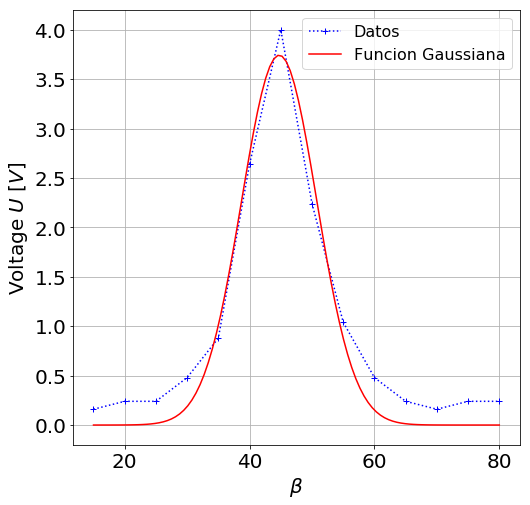

In [16]:
fig1

In [17]:
fig1.savefig('Figura1.jpg', dpi=100)
plt.close(fig1)

### Segunda parte de la fase 1.

#### Tabla 2. Verificación ley de la Reflexión

In [18]:
df['Tabla 2']

alpha  betha
0     10     10
1     20     11
2     30     26
3     40     36
4     50     46
5     60     57
6     70     68

### Calculo de la regresion lineal para la tabla 2.

### $$\beta_{\alpha}=m\alpha + b$$

In [19]:
pendiente, intercepto, r_valor, p_valor, std_err = stats.linregress(df['Tabla 2'].loc[:,'alpha'], df['Tabla 2'].loc[:,'betha'])
regresion = lambda x:pendiente*x+intercepto

In [49]:
r_valor

0.99252917984763656

In [70]:
std_err

1.2638879803474716

### Graficando regresion lineal y datos para la tabla 2.

In [20]:
fig2, axes2 = plt.subplots()
fig2.set_size_inches(8, 8)
axes2.grid(True)
axes2.set_xlabel(r'$\alpha$', fontsize=22)
axes2.set_ylabel(r'$\beta$', fontsize=22)
axes2.tick_params(labelsize=20)
axes2.scatter(df['Tabla 2'].loc[:,'alpha'], df['Tabla 2'].loc[:,'betha'], color='b', marker='o', label='Datos')
axes2.plot(range(0, df['Tabla 2'].loc[:,'alpha'].max()+1, 2), regresion(range(0, df['Tabla 2'].loc[:,'alpha'].max()+1, 2)), color='r', label=r'$\beta(\alpha) = %.4f \alpha + %.4f $' % (pendiente, intercepto))

In [21]:
legend2=axes2.legend(loc='best', fontsize=20)

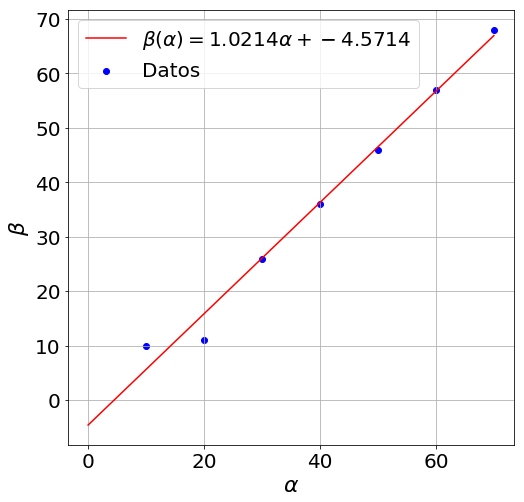

In [22]:
fig2

In [23]:
fig2.savefig('Figura2.jpg', dpi=100)
plt.close(fig2)

## ¿Se verifica la ley de la reflexión?

### Calculo de Error entre la unidad y la pendiente encontrada

### $$ErroExperimental_{\%} = 
\begin{vmatrix}
    \frac{ValorTeorico-ValorExperimental}{ValorTeorico}
 \end{vmatrix}*100
 $$

### $$ErroExperimental_{\%} = 
\begin{vmatrix}
    \frac{1-m}{1}
 \end{vmatrix}*100
$$

In [24]:
error_Unidad=abs((1-pendiente))*100
print('Error de: %.4f%%' % (error_Unidad))

Error de: 2.1429%


#### Tabla 3. Relación entre la distancia d a la placa de reflexión y el tiempo de tránsito de la señal.

La columna de distancias 'd' se multiplica por $10E-2$ para tener el valor en metros.
La columna de distancias 't' se multiplica por $10E-3$ para tener el valor en segundos y divide entre dos ya que el tiempo medido en el laboratorio era el de ida y vuelta

In [25]:
df['Tabla 3'].loc[:,'d'] *= 10E-3
df['Tabla 3'].loc[:,'t'] *= 10E-3/2
df['Tabla 3']

d        t
0  0.08  0.00500
1  0.16  0.00625
2  0.24  0.00875
3  0.32  0.01150
4  0.40  0.01375
5  0.48  0.01500
6  0.56  0.01850
7  0.64  0.02100

In [26]:
temperatura = 25

### Calculo de la regresion lineal para la tabla 3.

### $$d_{t}=vt + d_{0}$$

In [71]:
v_experimental, intercepto3, r_valor3, p_valor3, std_err2 = stats.linregress(df['Tabla 3'].loc[:,'t'], df['Tabla 3'].loc[:,'d'])
regresion3 = lambda t:v_experimental*t+intercepto3
v_experimental

34.315288272435566

In [75]:
std_err2

1.2638879803474716

### Graficando regresion lineal y datos para la tabla 3.

In [44]:
fig3, axes3 = plt.subplots()
fig3.set_size_inches(8, 8)
axes3.grid(True)
axes3.set_xlabel(r'$t [s]$', fontsize=20)
axes3.set_ylabel(r'$d [m]$', fontsize=20)
axes3.tick_params(labelsize=20)
axes3.scatter(df['Tabla 3'].loc[:,'t'], df['Tabla 3'].loc[:,'d'], color='C1', marker='o', label='Datos')
axes3.plot(np.linspace(0,df['Tabla 3'].loc[:,'t'].max(),2), regresion3(np.linspace(0,df['Tabla 3'].loc[:,'t'].max(),2)), color='g', label=r'$d_{t}=%.4f t + %.4f$' % (v_experimental*10, intercepto3))

In [45]:
legend3=axes3.legend(loc='best', fontsize=20)

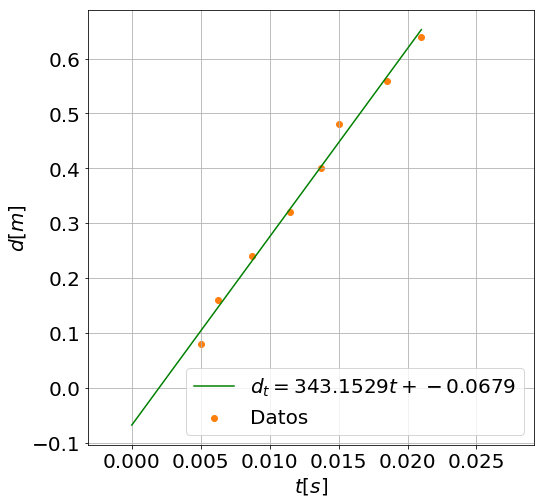

In [46]:
fig3

In [47]:
fig3.savefig('Figura3.jpg', dpi=100)
plt.close(fig3)

### $$v = 331.6 + 0.6T$$

In [32]:
v_teorica= 331.6+0.6*temperatura
v_teorica

346.6

#### Error entre las velocidades del sonido encontradas

In [33]:
(v_teorica-v_experimental*10)*100/v_teorica

0.99455201259214054

#### Tabla 4. Relación entre la distancia d a la placa de reflexión y el tiempo de tránsito de la señal con Obstaculo.

La columna de distancias 'd' se multiplica por $10E-2$ para tener el valor en metros.
La columna de distancias 't' se multiplica por $10E-3$ para tener el valor en metros y divide entre dos ya que el tiempo medido en el laboratorio era el de ida y vuelta

In [34]:
df['Tabla 4'].loc[:,'d'] *= 10E-3
df['Tabla 4'].loc[:,'t'] *= 10E-3/2
df['Tabla 4']

d       t
0  0.70  0.0225
1  0.15  0.0060
2  0.30  0.0100
3  0.45  0.0125

#### Tabla 5. distancia esperada con el modelo de la tabla 4 y su erro relativo.

In [35]:
df['Tabla 4']['d modelo']=regresion3(df['Tabla 4'].loc[:,'t'])
df['Tabla 4']['Error realtivo [%]']=abs(df['Tabla 4'].loc[:,'d']-df['Tabla 4'].loc[:,'d modelo'])*100/df['Tabla 4'].loc[:,'d']
df['Tabla 4']

d       t  d modelo  Error realtivo [%]
0  0.70  0.0225  0.704225            0.603605
1  0.15  0.0060  0.138023            7.984681
2  0.30  0.0100  0.275284            8.238623
3  0.45  0.0125  0.361072           19.761699

#### Coeficiente de determinacion entre los datos teoricos y experimentales de d para la talba 4.

In [51]:
R_tabla_4=R_square(df['Tabla 4']['d'], df['Tabla 4'].loc[:,'d modelo'])
R_tabla_4

0.9502761393360597

In [74]:
df['Estadsiticas']=pd.DataFrame({'Modelo': ['gausiana', 'tabla 2', 'tabla 3'], 'R cuadrado': [R_gausiano, r_valor, R_tabla_4], 'Desviacion estandar': [desviacion_gaussiana, std_err, std_err2]})
df['Estadsiticas']

Desviacion estandar    Modelo  R cuadrado
0             1.179709  gausiana    0.958914
1             1.263888   tabla 2    0.992529
2             1.263888   tabla 3    0.950276

In [37]:
def crear_hoja(nombre, df):
    from string import ascii_uppercase as letters
    fsheet=get_drive_sheet()
    resultsSheet = fsheet.add_worksheet(title=nombre, rows=str(df.shape[0]+100), cols=str(df.shape[1]+10))
#     resultsSheet=fsheet.get_worksheet(-1) TO DO: permitir escribir en una hoja especifica
    cell_list = resultsSheet.range(1, 1, df.shape[0]+1, df.shape[1])
    for cell in cell_list:
        if cell.row-1 ==0:
            cell.value=list(df)[(cell.col%df.shape[0])-1]
        else:
            cell.value=df.as_matrix()[cell.row-2][(cell.col%df.shape[0])-1]

    # Update in batch
    resultsSheet.update_cells(cell_list)

In [48]:
# crear_hoja('Ultima etapa', df['Tabla 4'])

 -*- coding: utf-8 -*-
Created on Fri Oct  6 19:39:05 2017